<h2>1. The distribution of distances between the edited adenines: the real <i>vs.</i> the expected one</h2>
<p>Let us define the <i>S</i> measure as:</p>
$$ S = crd_{i} - crd_{i-1} $$
<p>Where $crd_{i}$ is the position of $i$-th editing site on the considered sequence</p>
<p>First, we compute distributions of distances (measure <i>S</i>) between the real editing sites</p>
<p>Second, we compute the corresponding expected distribution: for each sequence we, preserving numbers of synonimous and non-synonimous editing sites, generate a set of random adenines and compute the <i>S</i> measure</p>
<p>The resulting distributions are then compared</p>
<p>We use the editing site data and transcriptomes generated by Liscovitch-Brauer et al., 2017</p>

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import re
import random
from editing_adlib import *
%matplotlib inline

In [2]:
def build_s_dist(edsite_crd_dict, norm = False, orf_crd_dict = None):
    s_dist = np.array([])
    for seq in edsite_crd_dict.keys():
        crd_arr = sorted(edsite_crd_dict[seq].keys())
        s_arr = []
        l = len(crd_arr)
        for i in range(1, l):
            s = crd_arr[i] - crd_arr[i-1]
            if norm:
                n = l*(orf_crd_dict[seq][1] - orf_crd_dict[seq][0])
                s = float(s)/n
            s_arr.append(s)
        s_dist = np.append(s_dist, s_arr)
    return s_dist
    
def build_random_s_dist(fastadict, edsite_crd_dict, orf_crd_dict, syn_nsyn = None):
    rand_edsite_crd_dict = dict()
    for seq_id in fastadict.keys():
        if not edsite_crd_dict.get(seq_id):
            continue
        rand_edsite_crd_dict[seq_id] = dict()
        orf = fastadict[seq_id][orf_crd_dict[seq_id][0]:orf_crd_dict[seq_id][1]]
        adenine_pos_arr = [i.start() for i in re.finditer("A", orf)]
        pos_num = len(edsite_crd_dict[seq_id].keys())
        pos_arr = random.sample(adenine_pos_arr, pos_num)
        for i in range(pos_num):
            rand_edsite_crd_dict[seq_id][pos_arr[i]] = True
#    print(rand_edsite_crd_dict)
    return rand_edsite_crd_dict
        

def build_figure(s_dist, fig_name = None):
    plt.hist(np.log10(s_dist), bins=20)
    if fig_name:
        plt.savefig(fig_name)
    plt.show()
    

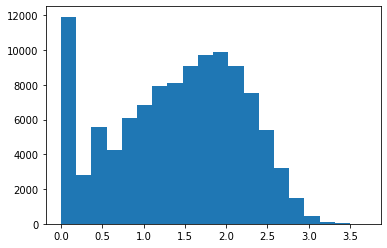

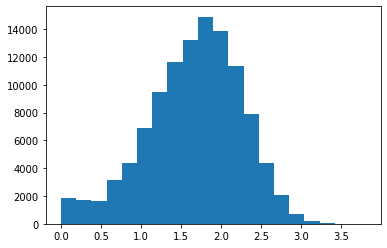

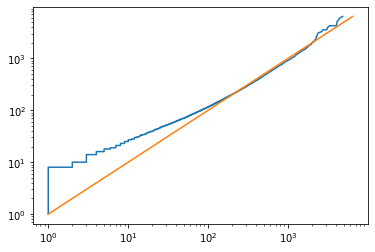

In [3]:
edsites_oct = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = None)
edsites_oct_syn = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = "syn")
edsites_oct_nsyn = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = "nsyn")
fastadict = readfasta("../data/orfs_oct_plus.fa")
orf_crd_dict = read_orf_crd_file("../data/oct_orf_crds.txt")

s = build_s_dist(edsites_oct)
build_figure(s, "../article/main_figures/fig2/oct_real_S_dist.pdf")
rand_s = build_s_dist(build_random_s_dist(fastadict, edsites_oct, orf_crd_dict, syn_nsyn = None))
build_figure(rand_s, "../article/main_figures/fig2/oct_random_S_dist.pdf")

plt.loglog(sorted(s),sorted(rand_s))
x = np.linspace(1,max(max(s), max(rand_s)))
plt.plot(x,x)
plt.savefig("../article/main_figures/fig2/oct_S_dist_compar.pdf")
plt.show()

In [4]:
def read_edsite_crd_file(edsite_crd_file, syn_nsyn = None):
    edsite_crd_dict = dict()
    with open(edsite_crd_file) as inhandle:
        for s in inhandle:
            if s[0] == '#':
                continue
            s = s.strip().split()
            if syn_nsyn == "syn" and s[4] != "syn":
                continue
            elif syn_nsyn == "nsyn" and s[4] == "syn":
                continue
            if not edsite_crd_dict.get(s[0]):
                edsite_crd_dict[s[0]] = dict()
            edsite_crd_dict[s[0]][eval(s[3])] = s
    return edsite_crd_dict

edsites_oct_syn = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = "syn")
edsites_oct_nsyn = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = "nsyn")

#for k in edsites_oct_nsyn.keys():
#    print(k, edsites_oct_nsyn[k])


<h3>1.1. The variance of the editing levels and its components.</h3>

Here, we calculate the editing levels variance of the total 
body of editing sites along with the variance explained by the transcript.
We do so with regard to the distances between sites.

$$ Var(EL) = Var(EL)_{within-transcr} + Var(EL)_{betweeen-transcr} $$
And we consider the function:
$$ \frac{Var(EL)_{betweeen-transcr}}{Var(EL)} <=> S_{thr} $$

<b>Discarded</b>: the error variance is larger than the effect variance

In [36]:
def calculate_var(edsite_crd_dict, s_thr, alpha = 0.05):
    total_arr = []
    within_transcr = []
    for gene_name in edsite_crd_dict.keys():
        crds = sorted(list(edsite_crd_dict[gene_name].keys()))
        new_crds = [crds[0]]
        for i in range(1, len(crds)):
            if crds[i] - new_crds[-1] > s_thr:
                new_crds.append(crds[i])
        if len(new_crds) < 2:
            continue
        vals_for_gene = []
        for crd in new_crds:
#            print(edsite_crd_dict[gene_name])
            el = eval(edsite_crd_dict[gene_name][crd][7])
            vals_for_gene.append(el)
            total_arr.append(el)
#        print(vals_for_gene)
        m = np.mean(vals_for_gene)
        vals_for_gene = [i - m for i in vals_for_gene]
        within_transcr += vals_for_gene
    
    err_means = []
    
    for gene_name in edsite_crd_dict.keys():
        l = len(edsite_crd_dict[gene_name].keys())
        if l < 2:
            continue
        ss = np.random.choice(total_arr, l)
        err_means.append(np.mean(ss))
    
    n = len(total_arr)
    df = n-1
    
    s_total = np.var(total_arr, ddof=1)
    s_within = np.var(within_transcr, ddof=1)
    print(np.var(err_means), s_total - s_within, s_total, s_within, s_within/s_total, len(total_arr), len(within_transcr))
    
    upper_total = (n - 1) * s_total / stats.chi2.ppf(alpha / 2, df)
    lower_total = (n - 1) * s_total / stats.chi2.ppf(1 - alpha / 2, df)
    
    upper_within = (n - 1) * s_within / stats.chi2.ppf(alpha / 2, df)
    lower_within = (n - 1) * s_within / stats.chi2.ppf(1 - alpha / 2, df)
    return s_total, upper_total, lower_total, upper_within, lower_within


#def 

arr_upper_total = []
arr_lower_total = []
arr_upper_within = []
arr_lower_within = []
a_upper = []
a_lower = []

#calculate_var(edsites_oct, -1, alpha = 0.05)
for i in [0,1,2,5,10,20,50,100,200,500,1000,1500,2000, 2500,3000,3500,4000]:
    s_total, upper_total, lower_total, upper_within, lower_within = calculate_var(edsites_oct, i, alpha = 0.05)
    a_upper.append(upper_within/s_total)
    a_lower.append(lower_within/s_total)
    arr_upper_total.append(upper_total)
    arr_lower_total.append(lower_total)
    arr_upper_within.append(upper_within)
    arr_lower_within.append(lower_within)

plt.plot(arr_upper_total, color="red")
plt.plot(arr_lower_total, color="red")
plt.plot(arr_upper_within, color="blue")
plt.plot(arr_lower_within, color="blue")
plt.show()
plt.plot(a_upper, color="red")
plt.plot(a_lower, color="red")
plt.show()

27.95136171502331 26.946179710789238 171.8814176044179 144.93523789362865 0.8432280808108914 116471 116471


KeyboardInterrupt: 

<h2>2. Correlations between editing levels of edjacent editing sites</h2>
<p>We calculate the Pearson's correlation coefficient for various distances between editing sites</p>

In [7]:
def pearsonr_ci(x,y, verbose, alpha=0.05/20):
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    if verbose:
        print(r, p, lo, hi, se)
    return r, p, lo, hi

def pearson_corr_arr(edsite_crd_dict, bin_arr, verbose=False):
    edlevel_dict = dict()
    for i in bin_arr:
        edlevel_dict[i] = []
    for seq_id in edsite_crd_dict.keys():
        edsite_crds = sorted(edsite_crd_dict[seq_id].keys())
        for i in range(len(edsite_crds) - 1):
            el1 = eval(edsite_crd_dict[seq_id][edsite_crds[i]][7])
            el2 = eval(edsite_crd_dict[seq_id][edsite_crds[i+1]][7])
            s_val = edsite_crds[i+1] - edsite_crds[i]
            for j in bin_arr:
                if j >= s_val:
                    edlevel_dict[j].append([el1,el2])
                    break
    cor_arr = []
    for i in bin_arr:
        if verbose:
            print(i)
        edlevel_dict[i] = np.array(edlevel_dict[i]).T
        try:
            p_cor = pearsonr_ci(edlevel_dict[i][0], edlevel_dict[i][1], verbose)
        except IndexError:
            p_cor = (0, 0, 0, 0)
#            p_cor = (np.nan, np.nan, np.nan, np.nan)
        cor_arr.append(p_cor)
#    print(cor_arr)
    return cor_arr

"""
def make_log_bin_arr(maxval, bin_num):
    log_bin_arr = []
    log_max = np.log10(maxval)
    r = log_max/bin_num
    for i in range(1, bin_num):
        val = 10**(r*i)
        log_bin_arr.append(val)
    return log_bin_arr
"""

def draw_correl(cor_arr, bin_arr, cutoff, fig_name = None):
    means = []
    low = []
    high = []
    for i in cor_arr[:-cutoff]:
        means.append(i[0])
        low.append(i[2])
        high.append(i[3])
    plt.plot(bin_arr[:-cutoff], means)
    plt.plot(bin_arr[:-cutoff], low)
    plt.plot(bin_arr[:-cutoff], high)
    plt.xscale('log')
    if fig_name:
        plt.savefig(fig_name)
    plt.show()
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



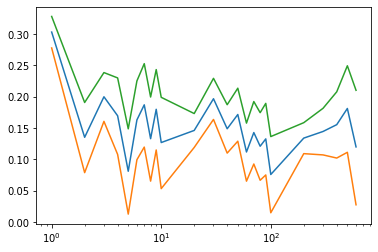

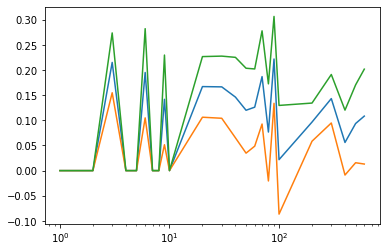

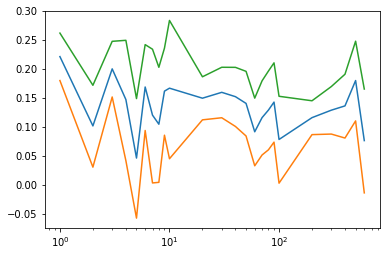

In [6]:
#bin_arr = make_log_bin_arr(10000, 20)
print(edsites_oct_syn)
bin_arr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,np.inf]
cor_arr = pearson_corr_arr(edsites_oct, bin_arr)
draw_correl(cor_arr, bin_arr, 1, "../article/main_figures/fig3/corr_EL.pdf")

bin_arr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,np.inf]
cor_arr = pearson_corr_arr(edsites_oct_syn, bin_arr)
draw_correl(cor_arr, bin_arr, 1, "../article/main_figures/fig3/corr_EL_syn.pdf")

bin_arr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,np.inf]
cor_arr = pearson_corr_arr(edsites_oct_nsyn, bin_arr)
draw_correl(cor_arr, bin_arr, 1, "../article/main_figures/fig3/corr_EL_nsyn.pdf")

1
2
3
0.21521750710268084 5.778035422763229e-26 0.1548924840345204 0.27394358790189927 0.0206680399887278
4
5
6
0.19524191821922984 1.162377428286945e-10 0.10488121576899823 0.28240523343014884 0.03059950306810523
7
8
9
0.14182434717111417 2.3316659576964564e-06 0.05145965233465347 0.22988553971264802 0.03019233393195842
10


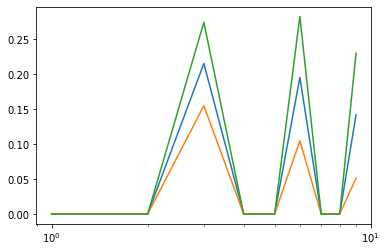

1
0.2212276723571647 7.21604075311276e-56 0.1799544048576697 0.2617233689128288 0.014226319992543996
2
0.10179054374284185 1.5375616309486638e-05 0.03075469801051794 0.17180329563491098 0.02360960823249428
3
0.20007868897184364 2.220563822352119e-34 0.1516544527267525 0.24754480432976714 0.016531748712584435
4
0.14722353837768962 2.563552850760403e-05 0.041915913429204435 0.24929602751492375 0.03517987723651459
5
0.04639300207714444 0.17532379768083284 -0.05708949804141657 0.14888923849890423 0.03425943549137658
6
0.16883524165606018 1.568223375085684e-11 0.0939119653227698 0.24185690914898153 0.025229689602299696
7
0.1203477514023736 0.001862704657874318 0.003517009036535411 0.23393733898938518 0.03883678186903087
8
0.1047225383282168 0.0015874207832615944 0.004553029321799989 0.2028113246777142 0.033259505261886965
9
0.16170889000228678 1.7623596505745705e-10 0.08578746888221805 0.23576313197750756 0.025515518153991442
10
0.1668214920021765 3.673163368081045e-05 0.04524447945113637 0

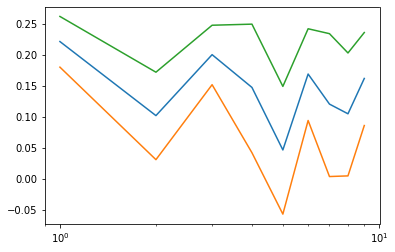

In [8]:
#Differences between correlations of syn and nsyn sites

bin_arr = [1,2,3,4,5,6,7,8,9,10]

cor_arr = pearson_corr_arr(edsites_oct_syn, bin_arr, verbose=True)
draw_correl(cor_arr, bin_arr, 1, "../article/main_figures/fig3/corr_EL_syn.pdf")

cor_arr = pearson_corr_arr(edsites_oct_nsyn, bin_arr, verbose=True)
draw_correl(cor_arr, bin_arr, 1, "../article/main_figures/fig3/corr_EL_nsyn.pdf")

#r, p, lo, hi, se

3: 0.21521750710268084, 0.0206680399887278, 0.20007868897184364, 0.016531748712584435
6: 0.19524191821922984, 0.03059950306810523, 0.16883524165606018, 0.025229689602299696
9: 0.14182434717111417, 0.03019233393195842, 0.16170889000228678, 0.025515518153991442

In [12]:
# 3: 0.21521750710268084, 0.0206680399887278, 0.20007868897184364, 0.016531748712584435
# 6: 0.19524191821922984, 0.03059950306810523, 0.16883524165606018, 0.025229689602299696
# 9: 0.14182434717111417, 0.03019233393195842, 0.16170889000228678, 0.025515518153991442

def p_norm(mean1, mean2, sd):
    Z = abs(mean1 - mean2)/sd
    print(Z, stats.norm.sf(Z))

p_norm(0.21521750710268084, 0.20007868897184364, 0.0206680399887278)
p_norm(0.21521750710268084, 0.20007868897184364, 0.016531748712584435)

p_norm(0.19524191821922984, 0.16883524165606018, 0.03059950306810523)
p_norm(0.19524191821922984, 0.16883524165606018, 0.025229689602299696)

p_norm(0.14182434717111417, 0.16170889000228678, 0.03019233393195842)
p_norm(0.14182434717111417, 0.16170889000228678, 0.025515518153991442)

#0.14763031549536548

0.7324747842124266 0.23193941399028922
0.9157420908117908 0.179901091484103
0.8629773007880683 0.1940749737036767
1.0466508696469532 0.14763031549536548
0.6585957506956734 0.2550776961573461
0.7793117392782412 0.2178980505428028


<h2>3. The distribution of the numbers of editing sites per editing cluster</h2>
<p>Now, we calculate the numbers of editing sites forming the cluster and compare
them with the expected distribution</p>

In [105]:
def edcluster_size_dist(edsite_crd_dict):
    size_dict = dict()
    for seq_id in edsite_crd_dict.keys():
        edsite_crds = sorted(edsite_crd_dict[seq_id].keys())
        clust_size = 1
        for i in range(1, len(edsite_crds)):
            if edsite_crds[i] == edsite_crds[i - 1] + 1:
                clust_size += 1
            else:
                if not size_dict.get(clust_size):
                    size_dict[clust_size] = 0
                size_dict[clust_size] += 1
                clust_size = 1
        if clust_size > 1:
            size_dict[clust_size] += 1
    return size_dict

def mkarr_from_dict(d):
    arr1 = [d[i] for i in sorted(d.keys())]
    arr2 = []
    for i in sorted(d.keys()):
        for j in range(d[i]):
            arr2.append(i)
    return arr1, arr2

[4.94230079 4.26245109 3.48742121 2.8739016  2.17609126 1.38021124
 0.84509804 0.90308999] [105701, 3508, 126]


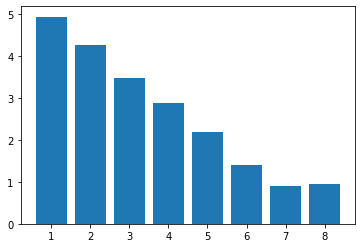

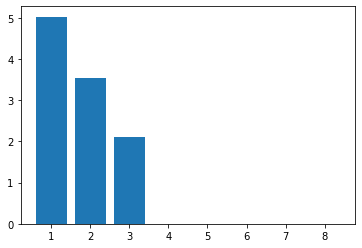

In [266]:
arr1, arr2 = mkarr_from_dict(edcluster_size_dist(edsites_oct))
rand_s = build_random_s_dist(fastadict, edsites_oct, orf_crd_dict, syn_nsyn = None)
brr1, brr2 = mkarr_from_dict(edcluster_size_dist(rand_s))
arr = []
for i in range(len(arr1)):
    arr.append(arr1[i]*(i+1))
brr = []
for i in range(len(brr1)):
    brr.append(brr1[i]*(i+1))
print(np.log10(arr), brr)
for i in range(len(brr),len(arr)):
    brr.append(0)
arr = np.array(arr)
brr = np.array(brr)
plt.bar(list(range(1, len(arr) + 1)),height=np.log10(arr + 1))
plt.savefig("../article/main_figures/fig2/clust_size_real.pdf")
plt.show()
plt.bar(list(range(1, len(arr) + 1)),height=np.log10(brr + 1))
plt.savefig("../article/main_figures/fig2/clust_size_rand.pdf")
plt.show()

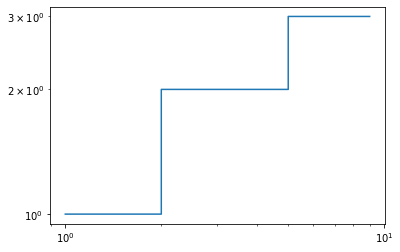

In [110]:
plt.loglog(arr2[-90000:], brr2[-90000:])

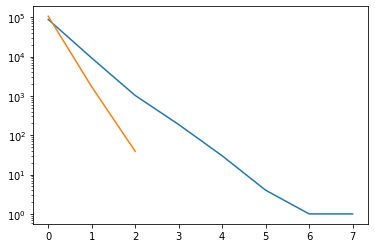

In [112]:
plt.semilogy([87559, 9150, 1024, 187, 30, 4, 1, 1])
plt.semilogy([105824, 1697, 39])

<h2>4. Editing clusters and conservative edted adenines</h2>
<p>We checked, whether nearby located edited adenines are more conserved than their individual counterparts</p>

In [123]:
def s1_proportion_compar(s_arr1, s_arr2):
    s1_1 = np.sum(s_arr1 == 1)
    s1_2 = np.sum(s_arr2 == 1)
    l1 = len(s_arr1)
    l2 = len(s_arr2)
    r1 = float(s1_1)/l1
    r2 = float(s1_2)/l2
    chi2, p, dof, ex = stats.chi2_contingency([[s1_1,l1],[s1_2,l2]], correction=False)
    print("{}\t{}\t{}".format(r1, r2, p))

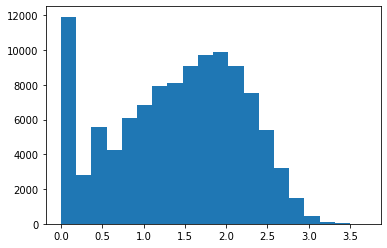

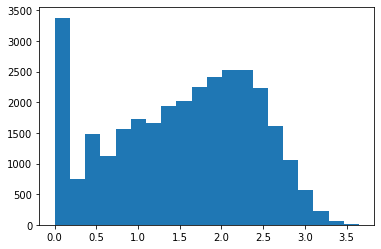

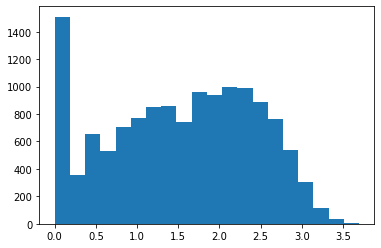

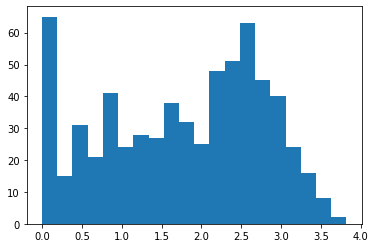

In [119]:
edsites_oct = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = None)
build_figure(np.log10(build_s_dist(edsites_oct)))
s_oct = build_s_dist(edsites_oct)
x1 = np.log10(s_oct)

edsites_oct_cons = read_edsite_crd_file("../data/bim_bim2oct_conserved_plus.txt", syn_nsyn = None)
build_figure(np.log10(build_s_dist(edsites_oct_cons)))
s_oct_cons = build_s_dist(edsites_oct_cons)
x2 = np.log10(s_oct_cons)

edsites_sep_cons = read_edsite_crd_file("../data/sep_sep2squ_conserved_plus.txt", syn_nsyn = None)
build_figure(np.log10(build_s_dist(edsites_sep_cons)))
s_sep_cons = build_s_dist(edsites_sep_cons)
x3 = np.log10(s_sep_cons)

edsites_all_cons = read_edsite_crd_file("../data/oct_all_conserved_plus.txt", syn_nsyn = None)
build_figure(np.log10(build_s_dist(edsites_all_cons)))
s_all_cons = build_s_dist(edsites_all_cons)
x4 = np.log10(s_all_cons)

In [120]:
rand_s = build_random_s_dist(fastadict, edsites_oct, orf_crd_dict, syn_nsyn = None)
rand_s_arr = build_s_dist(rand_s, norm = False, orf_crd_dict = None)

In [124]:
s1_proportion_compar(rand_s_arr, s_oct)
s1_proportion_compar(rand_s_arr, s_oct_cons)
s1_proportion_compar(rand_s_arr, s_sep_cons)
s1_proportion_compar(rand_s_arr, s_all_cons)
s1_proportion_compar(s_oct_cons, s_sep_cons)
s1_proportion_compar(s_oct_cons, s_all_cons)
s1_proportion_compar(s_sep_cons, s_all_cons)

0.016288880551259644	0.10902568701556595	0.0
0.016288880551259644	0.10850647056934588	0.0
0.016288880551259644	0.11155466844089598	0.0
0.016288880551259644	0.10093167701863354	5.969729040433368e-56
0.10850647056934588	0.11155466844089598	0.3958244789320584
0.10850647056934588	0.10093167701863354	0.5817322999162304
0.11155466844089598	0.10093167701863354	0.45143047684195325


<h2>5. Editing clusters and editing levels</h2>
<p>We checked, whether the editing levels of clustered editing sites are larger/smaller than those of individual sites</p>

In [308]:
def clust_edlevel_compar(edsite_crd_dict):
    clust_EL_dist = []
    ind_EL_dist = []
    for gene_id in edsite_crd_dict.keys():
        for crd in edsite_crd_dict[gene_id].keys():
            if edsite_crd_dict[gene_id].get(crd + 1):
                clust_EL_dist.append(eval(edsite_crd_dict[gene_id][crd][7]))
            elif edsite_crd_dict[gene_id].get(crd - 1):
                clust_EL_dist.append(eval(edsite_crd_dict[gene_id][crd][7]))
            else:
                ind_EL_dist.append(eval(edsite_crd_dict[gene_id][crd][7]))
#    print(clust_EL_dist)
    
    clust_EL_dist = np.array(clust_EL_dist)
    ind_EL_dist = np.array(ind_EL_dist)
                
    mean_clust = round(np.mean(clust_EL_dist), 6)
    std_clust = round(np.std(clust_EL_dist), 6)
        
    mean_ind = round(np.mean(ind_EL_dist), 6)
    std_ind = round(np.std(ind_EL_dist), 6)
    
    t, p = stats.mannwhitneyu(clust_EL_dist, ind_EL_dist)
    
    print("{}\t{}\t{}\t{}\t{}\t{}".format(mean_clust, std_clust, mean_ind, std_ind, float(mean_clust)/mean_ind, p))
    
    n_clust = len(clust_EL_dist)
    n_ind = len(ind_EL_dist)
    
    n_clust_high_EL = len([i for i in clust_EL_dist if i>50])
    n_ind_high_EL = len([i for i in ind_EL_dist if i>50])
    
    p1 = float(n_clust_high_EL)/n_clust
    p2 = float(n_ind_high_EL)/n_ind
    r = p1/p2
    
    chi2, p, dof, ex = stats.chi2_contingency([[n_clust_high_EL,n_clust],[n_ind_high_EL,n_ind]], correction=False)
    
    print("high_editing\t{}\t{}\t{}\t{}".format(p1,p2,r,p))
    
    return clust_EL_dist, ind_EL_dist
    
        

<class 'dict'>
10.098301	16.501235	6.293783	12.121199	1.6044882704090686	0.0
high_editing	0.047913585227018066	0.02153227748060839	2.2251982062820916	5.740380823062475e-101
12.494734	17.680551	8.819072	14.18008	1.4167855756251904	2.5060448252287816e-175
high_editing	0.05965285157633723	0.031204679108164535	1.9116636761289234	9.623912201142252e-55
9.88622	16.368693	6.819406	12.642368	1.4497186411837042	1.5272059391419799e-235
high_editing	0.046261717856870666	0.02334425350115907	1.981717592921689	2.8345263885154887e-84
16.683855	22.924564	11.980913	18.749779	1.392536194862612	7.092766043180727e-158
high_editing	0.10773891175125742	0.0628903923395287	1.7131219530258828	5.164908930932494e-78


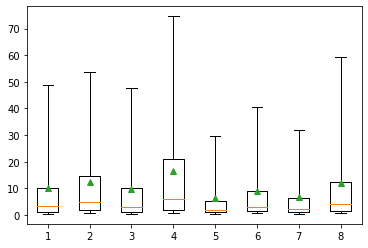

In [309]:
edsites_oct = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = None)
edsites_bim = read_edsite_crd_file("../data/editing_sites_bim_plus.txt", syn_nsyn = None)
edsites_sep = read_edsite_crd_file("../data/editing_sites_sep_plus.txt", syn_nsyn = None)
edsites_squ = read_edsite_crd_file("../data/editing_sites_squ_plus.txt", syn_nsyn = None)
print(type(edsites_oct))
clust_oct_EL_dist, ind_oct_EL_dist = clust_edlevel_compar(edsites_oct)
clust_bim_EL_dist, ind_bim_EL_dist = clust_edlevel_compar(edsites_bim)
clust_sep_EL_dist, ind_sep_EL_dist = clust_edlevel_compar(edsites_sep)
clust_squ_EL_dist, ind_squ_EL_dist = clust_edlevel_compar(edsites_squ)

list_vals = [clust_oct_EL_dist, \
             clust_bim_EL_dist, \
             clust_sep_EL_dist, \
             clust_squ_EL_dist, \
             ind_oct_EL_dist, \
             ind_bim_EL_dist, \
             ind_sep_EL_dist, \
             ind_squ_EL_dist]
plt.boxplot(list_vals, 0, '', whis = [5,95], showmeans=True)
plt.savefig("../article/main_figures/fig3/clust_VS_ind_ELs.pdf")
plt.show()

<h2>6. Directionality of editing site clusters</h2>
<p>We assesed whether there is directionality to the editing site clusters in the sense of higher EL of the upstream/downstream editing site in the clusters of two editing sites</p>

In [94]:
def edclust_direct(edsite_crd_dict, orf_crd_dict, size_two=True):
    diff_dist = [[],[],[]]
    for gene_id in edsite_crd_dict.keys():
        orfstart = orf_crd_dict[gene_id][0]
        for crd in edsite_crd_dict[gene_id].keys():
            if edsite_crd_dict[gene_id].get(crd + 1):
                if size_two and \
                (edsite_crd_dict[gene_id].get(crd + 2) or \
                edsite_crd_dict[gene_id].get(crd - 1)):
                    continue
                frame = (crd - orfstart)%3
                val_left = eval(edsite_crd_dict[gene_id][crd][7])
                val_right = eval(edsite_crd_dict[gene_id][crd + 1][7])
                diff_dist[frame].append(val_left - val_right)
    
    for frame in range(3):
    
        diff_dist[frame] = np.array(diff_dist[frame])
        
        mean_diff = round(np.mean(diff_dist[frame]), 6)
        std_diff = round(np.std(diff_dist[frame]), 6)
        
        t, p = stats.wilcoxon(diff_dist[frame])
        
        print("{}\t{}\t{}\t{}".format(frame, mean_diff, std_diff, p))
    return diff_dist

0	-4.768262	19.124919	8.51660880978413e-39
1	-3.999935	21.982675	3.209465149036477e-36
2	-2.304557	14.914374	4.77506404293694e-43


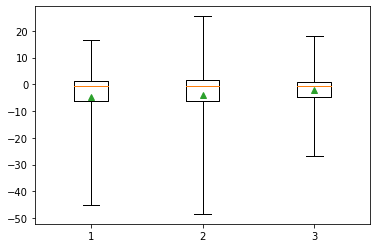

In [96]:
orf_crd_dict = read_orf_crd_file("../data/oct_orf_crds.txt")
diff_dist_oct = edclust_direct(edsites_oct, orf_crd_dict)
plt.boxplot(diff_dist_oct, 0, '', whis = [5,95], showmeans=True)
#plt.savefig("../article/main_figures/fig3/EL_direct.pdf")
plt.show()

0	-4.768262	19.124919	8.51660880978413e-39
1	-3.999935	21.982675	3.209465149036477e-36
2	-2.304557	14.914374	4.77506404293694e-43
0	-6.025283	19.800549	1.2388261478476222e-34
1	-4.500378	23.168436	9.375512907982424e-29
2	-2.120751	15.910338	7.852544809267939e-23
0	-4.159304	17.610217	1.151723873215292e-31
1	-4.463292	20.877688	1.3851897254534802e-62
2	-2.3173	15.131737	1.6998139187919555e-51
0	-9.080649	26.138276	1.276806331118097e-47
1	-6.432352	30.34241	1.7416810240375073e-39
2	-2.298938	24.855387	3.143584732127131e-19


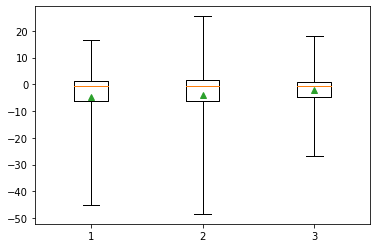

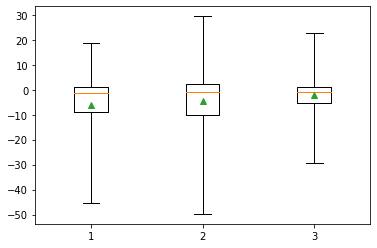

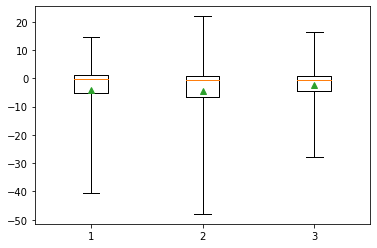

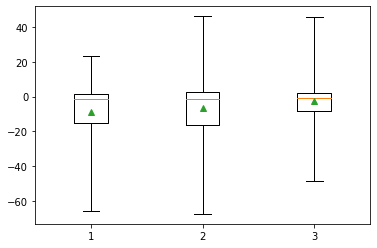

In [100]:
orf_crd_dict_oct = read_orf_crd_file("../data/oct_orf_crds.txt")
orf_crd_dict_bim = read_orf_crd_file("../data/bim_orf_crds.txt")
orf_crd_dict_sep = read_orf_crd_file("../data/sep_orf_crds.txt")
orf_crd_dict_squ = read_orf_crd_file("../data/squ_orf_crds.txt")

edsites_oct = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = None)
edsites_bim = read_edsite_crd_file("../data/editing_sites_bim_plus.txt", syn_nsyn = None)
edsites_sep = read_edsite_crd_file("../data/editing_sites_sep_plus.txt", syn_nsyn = None)
edsites_squ = read_edsite_crd_file("../data/editing_sites_squ_plus.txt", syn_nsyn = None)

diff_dist_oct = edclust_direct(edsites_oct, orf_crd_dict_oct)
diff_dist_bim = edclust_direct(edsites_bim, orf_crd_dict_bim)
diff_dist_sep = edclust_direct(edsites_sep, orf_crd_dict_sep)
diff_dist_squ = edclust_direct(edsites_squ, orf_crd_dict_squ)

list_vals = [diff_dist_oct, \
             diff_dist_bim, \
             diff_dist_sep, \
             diff_dist_squ]

for diff_dist in list_vals:
    plt.boxplot(diff_dist, 0, '', whis = [5,95], showmeans=True)
#plt.savefig("../article/main_figures/fig3/EL_direct.pdf")
    plt.show()

<h2>7. Directionality of editing site clusters #2</h2>
<p>Here, we compare the tendencies of the upstream/downstream sites to be non-synonimous</p>

In [254]:
def edclust_direct_syn(edsite_crd_dict, size_two=True):
    left_syn = 0
    right_syn = 0
    for gene_id in edsite_crd_dict.keys():
        for crd in edsite_crd_dict[gene_id].keys():
            if edsite_crd_dict[gene_id].get(crd + 1):
                if size_two and \
                (edsite_crd_dict[gene_id].get(crd + 2) or \
                edsite_crd_dict[gene_id].get(crd - 1)):
                    continue
                if edsite_crd_dict[gene_id][crd][4] == "syn":
                    left_syn += 1
                if edsite_crd_dict[gene_id][crd + 1][4] == "syn":
                    right_syn += 1
                    
    p = stats.binom_test(left_syn, left_syn + right_syn)
    r = float(left_syn)/(left_syn + right_syn)
    
    print("{}\t{}".format(r, p))
    
    return r

0.44035121206337086	6.073238986862696e-18
0.45878357517752394	2.9198657656465678e-06
0.4321657622101628	3.5794771370031885e-26
0.4448907858398192	3.730557004674848e-12


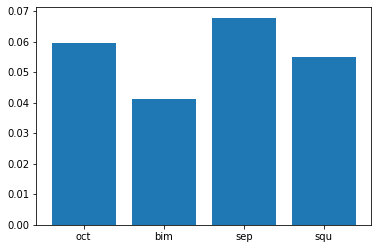

In [259]:
syn_prob_oct = edclust_direct_syn(edsites_oct)
syn_prob_bim = edclust_direct_syn(edsites_bim)
syn_prob_sep = edclust_direct_syn(edsites_sep)
syn_prob_squ = edclust_direct_syn(edsites_squ)


list_vals = [0.5 - syn_prob_oct, \
             0.5 - syn_prob_bim, \
             0.5 - syn_prob_sep, \
             0.5 - syn_prob_squ]

plt.bar(["oct","bim","sep","squ"], list_vals)
plt.savefig("../article/main_figures/fig3/syn_nsyn_clust.pdf")
plt.show()

<h2>8. Correlations between editing in adjacent sites</h2>
<p>Using the available RNAseq read data, we calculate correlations between the occurances of edited states on reads mapped onto the transcriptomes:</p>

$$ r_{i,j} = \frac{f_{i,j}^{AA}f_{i,j}^{GG} - f_{i,j}^{AG}f_{i,j}^{GA}}{\sqrt{f_i^A f_j^A f_i^G f_j^G}} $$

<p>Where $f_{i,j}^{N_1 N_2}$ are frequencies of co-occurencies of nucleotides $N_1$ and $N_2$ on the same read in positions $i$ and $j$ and $f_i^N$ are frequencies of the occurancies of the nucleotide $N$ in position $i$.</p>

<p>Next, we calculate the distributions of calculated $r$ values for specified $j-i$ distance ranges</p>
<p>The code works with the output of the script read_correl_count.py, that in turn utilizes the script call_edsite_variants.py which deals with raw .sam files containing read mapping data</p>


In [44]:
def correl_dist(read_correl_file, 
                edsite_crd_dict, 
                pval_thr=0.01, 
                el_both_thr=0, 
                el_max_thr=0,
                log_fig=False):
    
    ranges = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
    bonf_corr = len(ranges)
    list_vals = []
    means = []
    for i in ranges:
        list_vals.append([])
    for s in open(read_correl_file):
        s = s.strip().split()
        if not edsite_crd_dict.get(s[0]):
            continue
        if not edsite_crd_dict[s[0]].get(eval(s[1])):
            continue
        if not edsite_crd_dict[s[0]].get(eval(s[2])):
            continue
        el1 = eval(edsite_crd_dict[s[0]][eval(s[1])][7])
        el2 = eval(edsite_crd_dict[s[0]][eval(s[2])][7])
        if el1 < el_both_thr or el2 < el_both_thr:
            continue
        if max([el1, el2]) < el_max_thr:
            continue
        val = eval(s[3])
        for i in range(0,len(ranges)):
            if val <= ranges[i]:
                list_vals[i].append(eval(s[10]))
                break
    
    ranges_bins = dict()
    for i in range(len(ranges)):
        means.append(np.mean(list_vals[i]))
        ranges_bins[ranges[i]] = []
        for j in range(len(ranges)):
            t, p = stats.mannwhitneyu(list_vals[i],list_vals[j])
#            print(i,j,p)
            p = p*bonf_corr
            if p > pval_thr:
                ranges_bins[ranges[i]].append(ranges[j])
    
    if log_fig:
        plt.loglog(ranges, means)
        plt.savefig("../article/main_figures/fig3/read_correl.pdf")
        plt.show()
        return ranges_bins, list_vals, ranges, means
    else:
        plt.boxplot(list_vals, 0, '', whis = [5,95], showmeans=True)
        plt.plot(list(range(1, len(ranges) + 1)), means)
        plt.savefig("../article/main_figures/fig3/read_correl.pdf")
        plt.show()
        return ranges_bins, list_vals

In [20]:
edsites_oct = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = None)
edsites_oct_syn = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = "syn")
edsites_oct_nsyn = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = "nsyn")

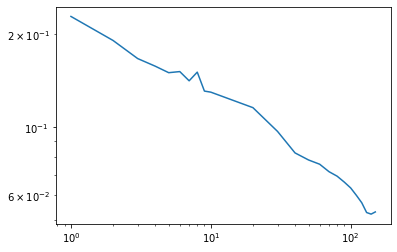

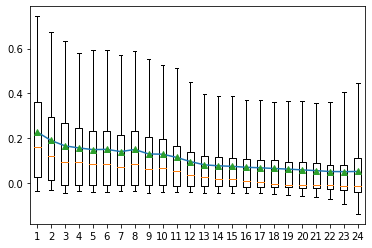

{1: [1], 2: [2], 3: [3, 4, 5, 6, 8], 4: [3, 4, 5, 6, 8], 5: [3, 4, 5, 6, 7, 8], 6: [3, 4, 5, 6, 7, 8], 7: [5, 6, 7, 8, 9, 10], 8: [3, 4, 5, 6, 7, 8], 9: [7, 9, 10], 10: [7, 9, 10], 20: [20], 30: [30], 40: [40], 50: [50, 60], 60: [50, 60, 70], 70: [60, 70, 80], 80: [70, 80], 90: [90], 100: [100, 110], 110: [100, 110], 120: [120], 130: [130], 140: [140, 150], 150: [140, 150]}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


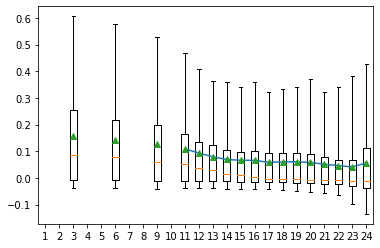

{1: [], 2: [], 3: [3, 6], 4: [], 5: [], 6: [3, 6, 9], 7: [], 8: [], 9: [6, 9, 20], 10: [], 20: [9, 20], 30: [30, 40], 40: [30, 40], 50: [50, 60, 70, 80], 60: [50, 60, 70, 80], 70: [50, 60, 70, 80, 90, 100], 80: [50, 60, 70, 80, 90, 100], 90: [70, 80, 90, 100, 110], 100: [70, 80, 90, 100, 110], 110: [90, 100, 110, 120], 120: [110, 120, 130, 150], 130: [120, 130, 140, 150], 140: [130, 140, 150], 150: [120, 130, 140, 150]}


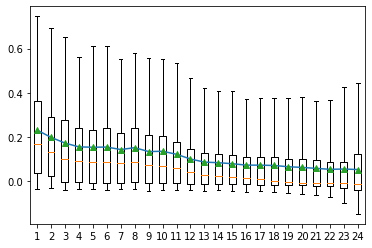

{1: [1], 2: [2], 3: [3, 4, 5, 6, 8], 4: [3, 4, 5, 6, 7, 8, 10], 5: [3, 4, 5, 6, 7, 8, 9, 10], 6: [3, 4, 5, 6, 7, 8, 10], 7: [4, 5, 6, 7, 8, 9, 10], 8: [3, 4, 5, 6, 7, 8, 9, 10], 9: [5, 7, 8, 9, 10, 20], 10: [4, 5, 6, 7, 8, 9, 10, 20], 20: [9, 10, 20], 30: [30], 40: [40, 50], 50: [40, 50, 60], 60: [50, 60, 70, 80], 70: [60, 70, 80, 90], 80: [60, 70, 80, 90], 90: [70, 80, 90], 100: [100, 110], 110: [100, 110, 120], 120: [110, 120], 130: [130, 140], 140: [130, 140, 150], 150: [140, 150]}


In [42]:
ranges_bins, list_vals, ranges, means = correl_dist("../data/read_correl_oct.tsv", 
                                     edsites_oct, 
                                     pval_thr = 0.01, 
                                     el_both_thr = 0, 
                                     el_max_thr = 0,
                                     log_fig = True)

ranges_bins, list_vals = correl_dist("../data/read_correl_oct.tsv", 
                                     edsites_oct, 
                                     pval_thr = 0.01, 
                                     el_both_thr = 0, 
                                     el_max_thr = 0)
print(ranges_bins)

ranges_bins_syn, list_vals_syn = correl_dist("../data/read_correl_oct.tsv", 
                                             edsites_oct_syn, 
                                             pval_thr = 0.01, 
                                             el_both_thr = 0, 
                                             el_max_thr = 0)
print(ranges_bins_syn)
ranges_bins_nsyn, list_vals_nsyn = correl_dist("../data/read_correl_oct.tsv", 
                                               edsites_oct_nsyn, 
                                               pval_thr = 0.01, 
                                               el_both_thr = 0, 
                                               el_max_thr = 0)
print(ranges_bins_nsyn)


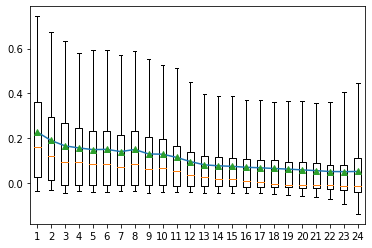

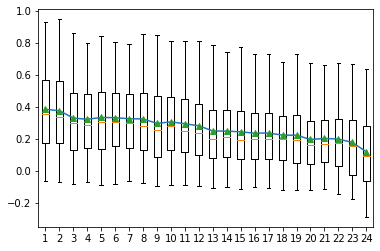

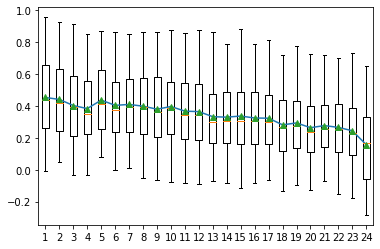

In [84]:
#Correlations for different EL thresholds
ranges_bins, list_val_0 = correl_dist("../data/read_correl_oct.tsv", 
                                     edsites_oct, 
                                     pval_thr = 0.01, 
                                     el_both_thr = 0, 
                                     el_max_thr = 0)

ranges_bins, list_vals_5 = correl_dist("../data/read_correl_oct.tsv", 
                                     edsites_oct, 
                                     pval_thr = 0.01, 
                                     el_both_thr = 5, 
                                     el_max_thr = 5)

ranges_bins, list_vals_10 = correl_dist("../data/read_correl_oct.tsv", 
                                     edsites_oct, 
                                     pval_thr = 0.01, 
                                     el_both_thr = 10, 
                                     el_max_thr = 10)

In [86]:
for i in range(len(list_val_0)):
    t, p = stats.mannwhitneyu(list_val_0[i],list_vals_5[i])
    print("WWWW", np.mean(list_val_0[i]), np.mean(list_vals_5[i]), p)
    t, p = stats.mannwhitneyu(list_vals_5[i],list_vals_10[i])
    print(np.mean(list_vals_5[i]), np.mean(list_vals_10[i]), p)

WWWW 0.22867676994899463 0.3842101258826143 2.363545222904947e-171
0.3842101258826143 0.4540059605726045 6.562412279393765e-16
WWWW 0.19109651971825334 0.3757828850254404 8.660021605052941e-78
0.3757828850254404 0.44174429163215195 2.9911371831148444e-05
WWWW 0.16691178149519878 0.3298724091297738 1.960925649327782e-114
0.3298724091297738 0.4033492153192123 1.1516854753266586e-09
WWWW 0.15771964970482644 0.3220183790981185 1.3983420661341772e-66
0.3220183790981185 0.38435149775497335 9.276548734447067e-05
WWWW 0.15020312702489788 0.333717549040313 8.251380238705632e-58
0.333717549040313 0.437445408078643 1.7568983535110065e-07
WWWW 0.151448789507787 0.3320226310272497 7.149521520294895e-82
0.3320226310272497 0.40464541615668465 2.55139153193553e-06
WWWW 0.14136552710538336 0.32566488353418926 3.029635761716584e-69
0.32566488353418926 0.41028456676463126 2.336250810941477e-06
WWWW 0.15083153739137364 0.3242571672722239 1.0486280522421915e-57
0.3242571672722239 0.3993645010003142 1.94918

In [34]:
#Comparison of syn and nsyn association correlations
print(len(list_vals), len(list_vals_syn[0]))

t, p = stats.mannwhitneyu(list_vals_syn[2],list_vals_nsyn[2])
print(p)
t, p = stats.mannwhitneyu(list_vals_syn[5],list_vals_nsyn[5])
print(p)
t, p = stats.mannwhitneyu(list_vals_syn[8],list_vals_nsyn[8])
print(p)

l1 = [*list_vals_syn[2], *list_vals_syn[5], *list_vals_syn[8]]
l2 = [*list_vals_nsyn[2], *list_vals_nsyn[5], *list_vals_nsyn[8]]
t, p = stats.mannwhitneyu(l1, l2)
print(p)

24 0
0.0015656923688136056
0.05763702952453333
0.06840436112528882
0.00020661715061827388


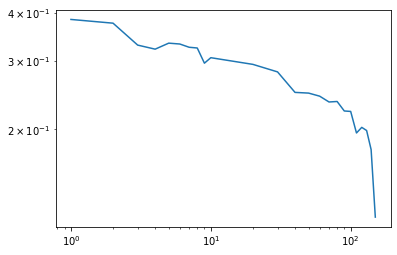

In [87]:
#Exponential_fit
ranges_bins, \
list_vals, \
ranges, \
means = correl_dist("../data/read_correl_oct.tsv", 
                    edsites_oct, 
                    pval_thr = 0.01, 
                    el_both_thr = 5, 
                    el_max_thr = 5,
                    log_fig = True)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
[0.3842101258826143, 0.3757828850254404, 0.3298724091297738, 0.3220183790981185, 0.333717549040313, 0.3320226310272497, 0.32566488353418926, 0.3242571672722239, 0.2962833372947533, 0.3060916368696638, 0.29416540981564065, 0.2813147886222289, 0.24905078318627097, 0.24802095321475298, 0.24353841835446338, 0.23526373835957592, 0.23595205655791637, 0.22302575479596445, 0.2223976641040661, 0.19568355191964343, 0.20231672752319982, 0.19857370956443932, 0.17726908472562583, 0.11868849362395967]
1


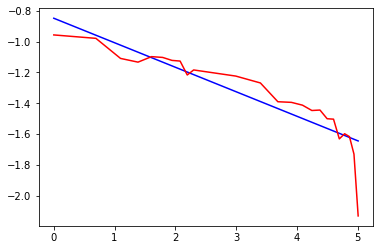

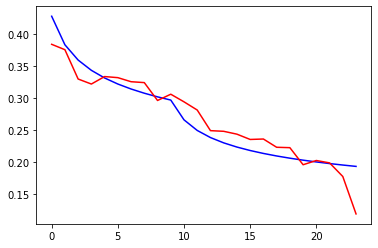

In [88]:


print(ranges)
print(means)
l_ranges = np.log(ranges)
l_means = np.log(means)
print(1)
gradient, intercept, r_value, p_value, std_err = stats.linregress(l_ranges, l_means)
x = l_ranges
y = gradient*x + intercept
plt.plot(x, y, color="blue")
plt.plot(l_ranges, l_means, color = "red")
plt.show()

plt.plot(list(range(len(ranges))), np.exp(y), color="blue")
plt.plot(list(range(len(ranges))), np.exp(l_means), color = "red")
plt.show()

In [92]:
#Checking if correlations indeed differ from the exponential expectation
def eq_0_t_test(dist):
    dist_mean = np.mean(dist)
    dist_std = np.std(dist)/(np.sqrt(len(dist) -3))
    Z = dist_mean/(dist_std)
    return Z, stats.norm.sf(Z)


l = len(list_vals)

for i in range(l):
    ar = np.array(list_vals[i])
#    print(np.exp(l_means[i]))
    br = ar - np.exp(y[i])
    print(np.mean(list_vals[i]), np.mean(br), eq_0_t_test(br)) 

    
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, -48, 49, 56, 60, -67, 75]
print(stats.wilcoxon(d))
#list_vals

0.3842101258826143 -0.043948963276763175 (-8.05229011253119, 0.9999999999999996)
0.3757828850254404 -0.007712556709795431 (-0.7585920089781786, 0.7759516728086507)
0.3298724091297738 -0.029688688774791326 (-4.00399001623204, 0.9999688585029037)
0.3220183790981185 -0.021472527799244946 (-2.1517609325010882, 0.9842919058548276)
0.333717549040313 0.002195355487549176 (0.18131776316173442, 0.42805908206242405)
0.3320226310272497 0.009969343912773595 (1.0172577627905355, 0.15451541189904888)
0.32566488353418926 0.011406133051317614 (1.0372825961770584, 0.14980208714248167)
0.3242571672722239 0.01659770048088081 (1.4403824604692586, 0.07487961158661313)
0.2962833372947533 -0.005670273873855305 (-0.5188406091281846, 0.6980640516867388)
0.3060916368696638 0.009152360603999689 (0.7624665659046632, 0.22289079522967853)
0.29416540981564065 0.028201515078249122 (6.6194885003527775, 1.802219401801216e-11)
0.2813147886222289 0.031949973327309304 (6.461109258174319, 5.196911893747893e-11)
0.249050783

In [77]:
d = np.array([6, 8, 14, 16, 23, 24, 28, 29, 41, -48, 49, 56, 60, -67, 75])
print(stats.wilcoxon(d))
d = np.array([-6, 8, -14, -16, 23, 24, 28, 29, 41, -48, 49, 56, 60, -67, 75])
print(stats.wilcoxon(d))
d = np.array([6, 8, 14, 16, 23, 24, 28, 29, 41, 48, 49, 56, 60, 67, 75])
print(stats.wilcoxon(d))

WilcoxonResult(statistic=24.0, pvalue=0.04088813291185591)
WilcoxonResult(statistic=32.0, pvalue=0.11176874513967605)
WilcoxonResult(statistic=0.0, pvalue=0.0006549583433856954)


<h2>9. Structural potential at editing sites</h2>
<p>We have calculated the RNA structure Z scores for regions incorporatind editing sites. Now we compare the structural potentials Z-score distributions in clustered vs. in individual sites</p>

In [101]:
def z_score_clust_dict(edsite_z_score_file, z_score_thr = 0):
    z_dict = dict()
    with open(edsite_z_score_file) as inhandle:
        for s in inhandle:
            s = s.strip().split()
            s = s[1:]
#            print(s)
            if s[0].startswith('#'):
                continue
            if not z_dict.get(s[0]):
                z_dict[s[0]] = dict()
            z_dict[s[0]][eval(s[3])] = eval(s[-2])
#            z = eval(s[-2])
#            if abs(z) > z_score_thr:
#                z_dict[s[0]][eval(s[3])] = z
    return z_dict

def z_dist_clust(z_dict, edsite_crd_dict):
    clust_z = []
    unclust_z = []
    for seq_id in edsite_crd_dict.keys():
        edsite_crds = sorted(edsite_crd_dict[seq_id].keys())
        clust_size = 1
        clusts = []
        clust = []
        unclust = []
        for i in edsite_crds:
            if i+1 in edsite_crds:
                clust.append(i)
                clust.append(i+1)
            elif i-1 in edsite_crds:
                clust.append(i)
                clust.append(i-1)
            else:
                unclust.append(i)
        for i in clust:
            clust_z.append(z_dict[seq_id][i])
        for i in unclust:
            unclust_z.append(z_dict[seq_id][i]) 
    return [clust_z, unclust_z]

def print_fig(z_dist, fig_name):
    ll = []
    for i in sorted(z_dist.keys()):
        ll.append(z_dist[i])
    plt.boxplot(ll, 0, '', whis = [5,95], showmeans=True)
    plt.savefig(fig_name)
    plt.show()
    
    

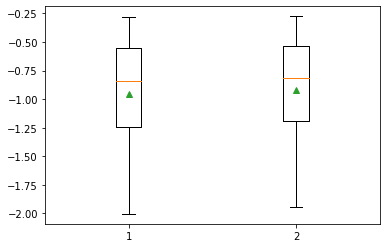

-0.9544842634671702
-0.9242486787104195


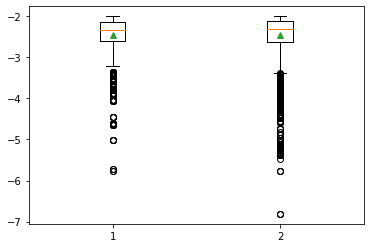

MannwhitneyuResult(statistic=2064970360.5, pvalue=2.3991191451803457e-21)


In [305]:
z_dict = z_score_clust_dict("../data/editing_sites_oct_plus_extended.txt", z_score_thr = 0)
#print(z_dict)
z_dist = z_dist_clust(z_dict, edsites_oct)
#print(z_dist)
plt.boxplot(z_dist, 0, '', whis = [5,95], showmeans=True)
plt.savefig("../article/main_figures/fig4/tmp.pdf")
plt.show()
print(np.mean(z_dist[0]))
print(np.mean(z_dist[1]))
a = [i for i in z_dist[0] if i < -2]
b = [i for i in z_dist[1] if i < -2]
plt.boxplot([a,b], 0,showmeans=True)
plt.savefig("../article/main_figures/fig4/tmp.pdf")
plt.show()
print(stats.mannwhitneyu(z_dist[0],z_dist[1]))
#print_fig(z_dist, "../article/main_figures/fig4/tmp.pdf")

<h2>10. Variances attributed to contexts and structures</h2>
<p>Here, we calculate the proportions of the EL variance for which the local contexts
or RNA structural potentials are responsible</p>

In [114]:
def context_EL_dists(fastadict, edsites_dict, el_thr = 0):
    all_ELs = []
    context_EL_dict = {}
    for seq_id in edsites_dict.keys():
        seq = fastadict[seq_id]
        for crd in edsites_dict[seq_id].keys():
            context = seq[crd-2] + seq[crd]
            if not context_EL_dict.get(context):
                context_EL_dict[context] = []
            el = eval(edsites_dict[seq_id][crd][7])
            if el > el_thr:
                context_EL_dict[context].append(el)
                all_ELs.append(eval(edsites_dict[seq_id][crd][7]))
    return context_EL_dict, all_ELs

In [106]:
z_dict = z_score_clust_dict("../data/editing_sites_oct_plus_extended.txt", z_score_thr = 0)
fastadict = readfasta("../data/orfs_oct_plus.fa")
edsites_oct = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = None)

In [116]:
context_EL_dict, all_ELs = context_EL_dists(fastadict, edsites_oct, 0)

var_all = np.var(all_ELs, ddof=1)
mean_vars = []
for i in context_EL_dict.keys():
    mean_vars.append(np.mean(context_EL_dict[i]))
var_cont = np.var(mean_vars, ddof=1)
n = len(mean_vars)
df = n-1
alpha = 0.05
upper_total = (n - 1) * var_cont / stats.chi2.ppf(alpha / 2, df)
lower_total = (n - 1) * var_cont / stats.chi2.ppf(1 - alpha / 2, df)
print(lower_total/var_all, var_cont/var_all, upper_total/var_all)

context_EL_dict, all_ELs = context_EL_dists(fastadict, edsites_oct, 5)

var_all = np.var(all_ELs, ddof=1)
mean_vars = []
for i in context_EL_dict.keys():
    mean_vars.append(np.mean(context_EL_dict[i]))
var_cont = np.var(mean_vars, ddof=1)
n = len(mean_vars)
df = n-1
alpha = 0.05
upper_total = (n - 1) * var_cont / stats.chi2.ppf(alpha / 2, df)
lower_total = (n - 1) * var_cont / stats.chi2.ppf(1 - alpha / 2, df)
print(lower_total/var_all, var_cont/var_all, upper_total/var_all)

context_EL_dict, all_ELs = context_EL_dists(fastadict, edsites_oct, 10)

var_all = np.var(all_ELs, ddof=1)
mean_vars = []
for i in context_EL_dict.keys():
    mean_vars.append(np.mean(context_EL_dict[i]))
var_cont = np.var(mean_vars, ddof=1)
n = len(mean_vars)
df = n-1
alpha = 0.05
upper_total = (n - 1) * var_cont / stats.chi2.ppf(alpha / 2, df)
lower_total = (n - 1) * var_cont / stats.chi2.ppf(1 - alpha / 2, df)
print(lower_total/var_all, var_cont/var_all, upper_total/var_all)


context_EL_dict, all_ELs = context_EL_dists(fastadict, edsites_oct, 20)

var_all = np.var(all_ELs, ddof=1)
mean_vars = []
for i in context_EL_dict.keys():
    mean_vars.append(np.mean(context_EL_dict[i]))
var_cont = np.var(mean_vars, ddof=1)
n = len(mean_vars)
df = n-1
alpha = 0.05
upper_total = (n - 1) * var_cont / stats.chi2.ppf(alpha / 2, df)
lower_total = (n - 1) * var_cont / stats.chi2.ppf(1 - alpha / 2, df)
print(lower_total/var_all, var_cont/var_all, upper_total/var_all)

0.003911022710775498 0.007167181918109639 0.01716789573949355
0.008445870794847949 0.015477560965510654 0.037074146574421755
0.01218695268026223 0.022333316205549167 0.05349606700580815
0.015459547134401364 0.028330540341422582 0.06786150657012227


In [118]:
def EL_Z_cor(edsites_dict, z_dict, el_thr=0):

    vec_EL = []
    vec_Z = []
    
    for gene_id in edsites_dict.keys():
        for crd in edsites_dict[gene_id].keys():
            el = eval(edsites_dict[gene_id][crd][7])
            if el > el_thr:
                vec_EL.append(el)
                vec_Z.append(z_dict[gene_id][crd])
    
    vec_EL = np.array(vec_EL)
    vec_Z = np.array(vec_Z)
    
    s1 = np.std(vec_EL)
    s2 = np.std(vec_Z)
    
    vec_EL = vec_EL/s1
    vec_Z = vec_Z/s2
    
    print(el_thr, stats.pearsonr(vec_EL, vec_Z))

for i in range(0,100,5):
    EL_Z_cor(edsites_oct, z_dict, el_thr=i)

0 (-0.1372650995293891, 0.0)
5 (-0.1569765102043012, 1.9887780124884549e-187)
10 (-0.17538415519726547, 1.829733501437466e-136)
15 (-0.18139174835224675, 4.3053616149483225e-104)
20 (-0.17975995297268313, 4.592443968037231e-78)
25 (-0.1887642972800177, 1.3142687294648544e-68)
30 (-0.1899263896311052, 1.1181388711222475e-56)
35 (-0.17424864807428456, 1.0497574715846874e-39)
40 (-0.14890556777396477, 2.963301309880371e-24)
45 (-0.11463809414224227, 1.198633015873831e-12)
50 (-0.07167233269677822, 6.051279227211082e-05)
55 (-0.0735540335693878, 0.00012468824910126904)
60 (-0.0420937826514993, 0.046418577585985554)
65 (-0.017052799477274855, 0.47213766928788053)
70 (8.707634250328751e-05, 0.9974791328076279)
75 (-0.008218006524134517, 0.8037301685116145)
80 (-0.044392023251616335, 0.28292558198781154)
85 (0.004483930449099346, 0.9355232158739253)
90 (-0.15801159752194233, 0.07720847888850879)
95 (-0.17835624929390081, 0.3546117112882249)


<h2>11. Probabilities of adenine editing depending on the distance to the nearest ES</h2>
We calculate the probabilities of adenine editing for different distances for the real data and for the null model

In [123]:
def editing_prob(edsites_dict, fastadict):
    double_ed = {}
    single_ed = {}
    for gene_id in edsites_dict.keys():
        seq = fastadict[gene_id]
        es_crds = sorted(list(edsites_dict[gene_id].keys()))
        l = len(es_crds)
        ind = 0
        for i in range(l-1):
            k = es_crds[i+1] - es_crds[i]
            if not double_ed.get(k):
                double_ed[k] = 0
            double_ed[k] += 1
        
        curr_es_ind = 0
        for i in range(len(seq)):
            if seq[i] != 'A':
                continue
                
            l1 = abs(es_crds[curr_es_ind] - i)
            
            if curr_es_ind + 1 == l:
                l2 = l1
            else:
                l2 = abs(es_crds[curr_es_ind + 1] - i)
            
            if l1 > l2:
                curr_es_ind += 1
                l_min = l2
            else:
                l_min = l1
                
            if not single_ed.get(l_min):
                single_ed[l_min] = 0
            single_ed[l_min] += 1
            
    return double_ed, single_ed                   

In [124]:
edsites_oct = read_edsite_crd_file("../data/editing_sites_oct_plus.txt", syn_nsyn = None)
fastadict = readfasta("../data/orfs_oct_plus.fa")
rand_s_sites = build_random_s_dist(fastadict, edsites_oct, orf_crd_dict, syn_nsyn = None)

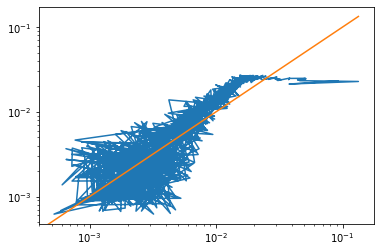

In [125]:
double_ed_r, single_ed_r = editing_prob(edsites_oct, fastadict)
double_ed_0, single_ed_0 = editing_prob(rand_s_sites, fastadict)

real_arr = []
rand_arr = []

for i in sorted(double_ed_r.keys()):
    if double_ed_0.get(i):
        real_arr.append(float(double_ed_r[i])/single_ed_r[i])
        rand_arr.append(float(double_ed_0[i])/single_ed_0[i])

plt.loglog(real_arr, rand_arr)
x = np.linspace(0,max(max(real_arr), max(rand_arr)))
plt.plot(x,x)
plt.show()

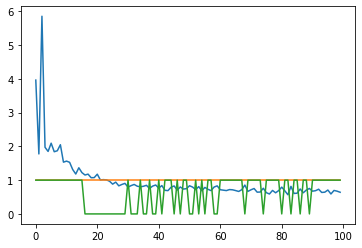

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [137]:
real_arr = []
rand_arr = []
ratio_arr = []
unit_arr = []
stat_sign_arr = []
sign_thr = 0.0001

for i in sorted(double_ed_r.keys()):
    if double_ed_0.get(i):
        real_arr.append(float(double_ed_r[i])/single_ed_r[i])
        rand_arr.append(float(double_ed_0[i])/single_ed_0[i])
        ratio_arr.append(real_arr[-1]/rand_arr[-1])
        unit_arr.append(1)
        chi2, p, dof, ex = stats.chi2_contingency([[double_ed_r[i],
                                                    single_ed_r[i]],
                                                   [double_ed_0[i],
                                                    single_ed_0[i]]], correction=False)
        if p < sign_thr:
            stat_sign_arr.append(1)
        else:
            stat_sign_arr.append(0)

plt.plot(ratio_arr[:100])
plt.plot(unit_arr[:100])
plt.plot(stat_sign_arr[:100])
plt.show()

print(stat_sign_arr[:100])

In [138]:
len([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

16